Reference: \
Modified version of Aurélien Geron's notebook for Chapter 14 – Deep Computer Vision Using Convolutional Neural Networks,
from Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition

# Setup

In [1]:
# Load libs and sklearn images: let's make use ofsklearn.datasets module in scikit-learn

from sklearn.datasets import load_sample_images
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Define the default font sizes to make the figures prettier:

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Convolutional Layers
## Implementing Convolutional Layers With Keras

`Preprocessing`<br>
Let's load two sample images.
1. Rescale their pixel values to 0-1<br>
2. Center crop them to small 70×120 images

In [3]:
images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

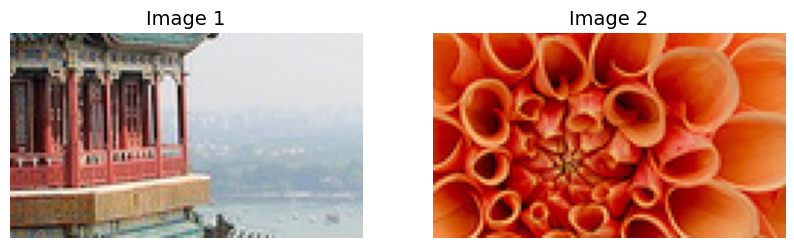

In [ ]:
# visualize 2 images
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(images[0])
plt.title("Image 1")
plt.axis("off")

plt.subplot(122)
plt.imshow(images[1])
plt.title("Image 2")
plt.axis("off")

plt.show()

Q.1. What does each dimension here represent?<br>

In [ ]:
images.shape

TensorShape([2, 70, 120, 3])

`Convolutional Layer`

Let's create a 2D convolutional layer and use on our two images. \
Keras provides a Convolution2D layer, alias Conv2D. This layer relies on TensorFlow’s tf.nn.conv2d() operation.

Create: <br>
a) a convolutional layer with `32 filters each of size 7 × 7` (using *kernel_size*=7, which is equivalent to using *kernel_size*=(7 , 7)) <br> b) apply this layer to our small batch of two images:

In [ ]:
tf.random.set_seed(42)  # ensures reproducibility
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

`Questions`

1.The default *stride* in TensorFlow's `Conv2D` is *_____*.<br>
2.By default, `Conv2D` uses "*_____*" *padding*.

In [ ]:
fmaps.shape

TensorShape([2, 64, 114, 32])

`Questions`

`Output Shape` Calculation (with valid padding):<br>
Height: (input_height - kernel_height + 1) = (*`__`* **-** *`__`* + 1) = `64`<br>
Width: (input_width - kernel_width + 1) = (*`__`* **-** *`__`* + 1) = `114`
<br><br>Q. What about using the same input, kernel, and padding, but with a stride of 2?

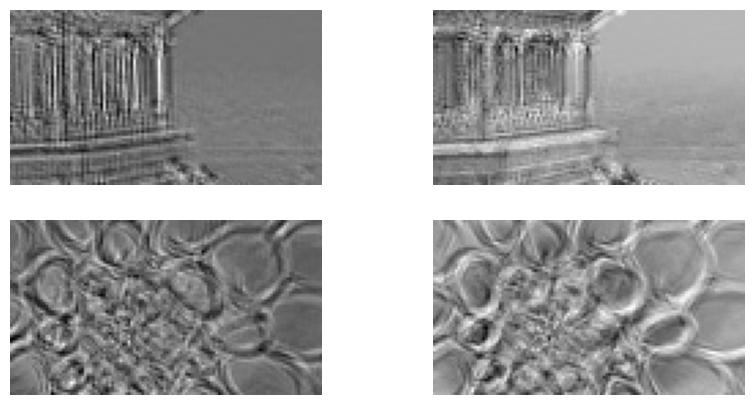

In [ ]:
# display the two output feature maps for each image

plt.figure(figsize=(10, 5))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

As you can see, `randomly generated filters` typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually `learns improved filters` to recognize useful patterns for the task.

`32 Feature Maps`

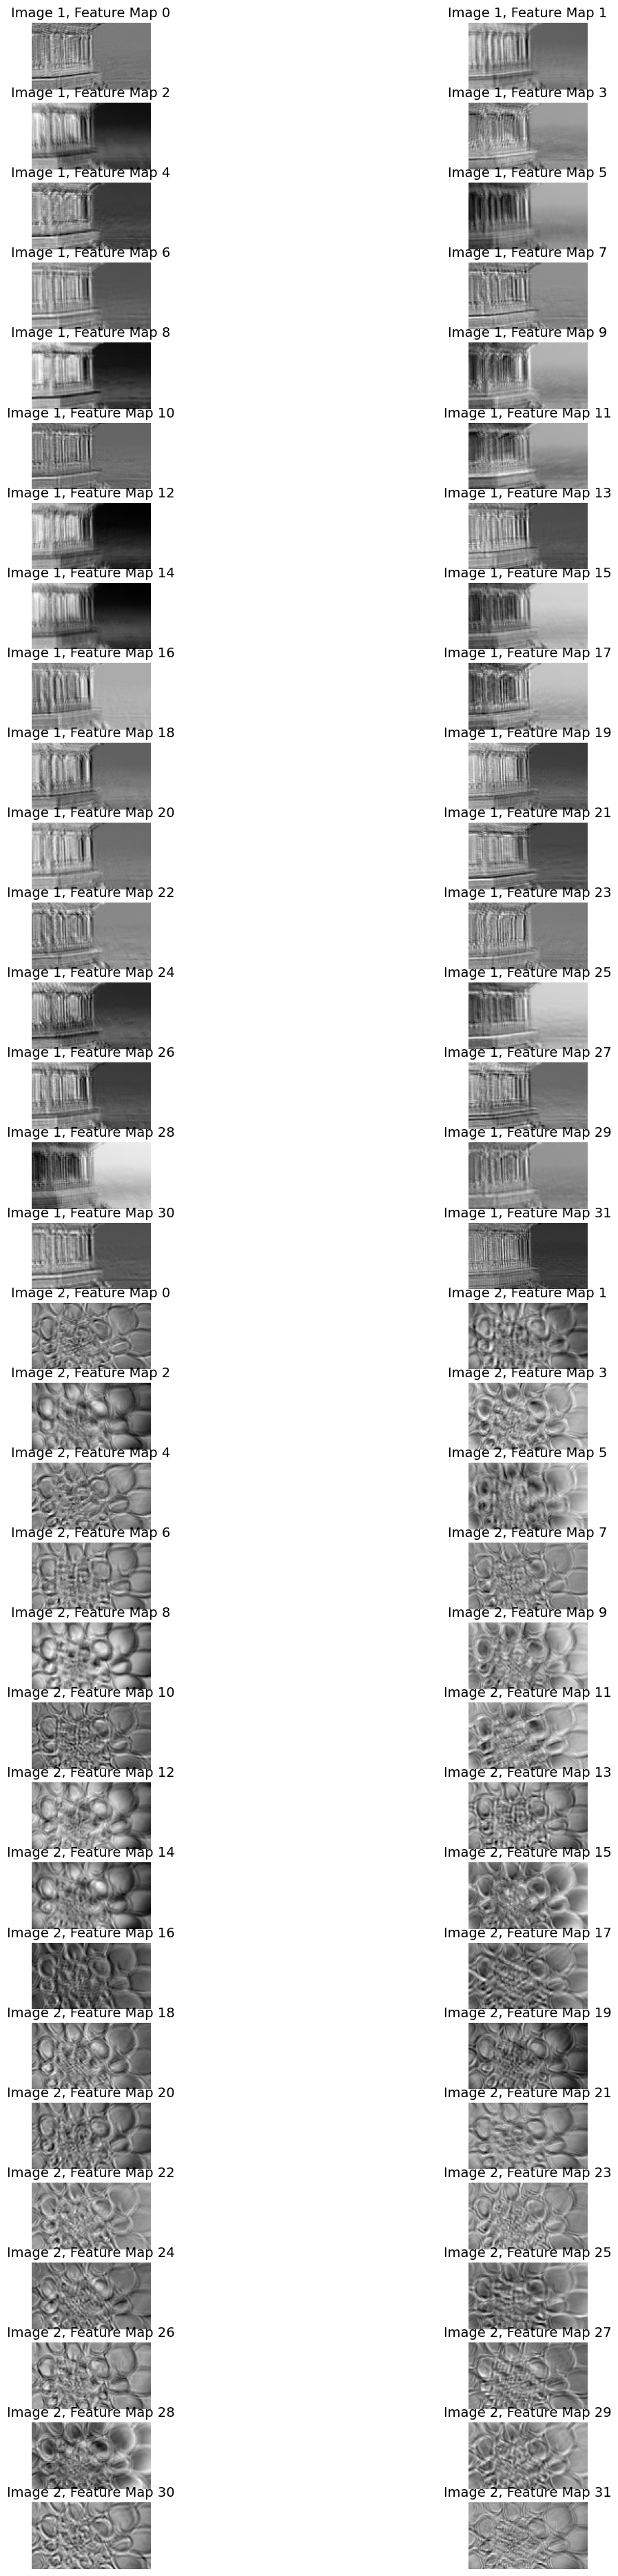

In [ ]:
plt.figure(figsize=(15, 48)) # figure height to accommodate all feature maps
for image_idx in (0, 1):
    for fmap_idx in range(32):  # Iterate through all 32 feature maps
        plt.subplot(32, 2, image_idx * 32 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.title(f"Image {image_idx + 1}, Feature Map {fmap_idx}")
        plt.axis("off")
plt.show()

`Padding`<br>
Now let's use zero-padding:

In [ ]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [ ]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [ ]:
# output shape when we set strides=2
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [ ]:
# this utility function can be useful to compute the size of the
# feature maps output by a convolutional layer. It also returns
# the number of ignored rows or columns if padding="valid", or the
# number of zero-padded rows or columns if padding="same".

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

Let's now look at the `weights, biases`:

In [ ]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [ ]:
biases.shape

(32,)

Let's take a look at the kernel's `weights`.\
The kernels array is 4D with the shape: `[kernel_height, kernel_width, input_channels, output_channels]`. \
The biases array is 1D with the shape: `[output_channels]`. \
The number of `output channels is equal to the number of output feature maps`, which is also equal to the number of filters.

In [ ]:
kernels[:, :, 0, 0]

array([[-0.05005217, -0.03188482, -0.02521109,  0.05439936,  0.00985831,
         0.03345313,  0.02932115],
       [ 0.01949865,  0.01270235,  0.02666407,  0.027948  ,  0.04789719,
         0.0330486 , -0.02710297],
       [ 0.03834697,  0.05775059, -0.05255133, -0.00951889,  0.03600519,
        -0.02709953,  0.02665969],
       [-0.02351643,  0.00313873, -0.01752589, -0.00935406,  0.02829901,
         0.02899496,  0.03114705],
       [-0.03068265, -0.02035402,  0.02322081,  0.00821406, -0.04619511,
         0.0242441 ,  0.05735087],
       [-0.04130805, -0.05599028,  0.02790646, -0.02189648,  0.03532081,
        -0.01914429, -0.00513972],
       [ 0.04524013, -0.03442216,  0.05415452, -0.01440829,  0.05903419,
        -0.0457931 ,  0.02503584]], dtype=float32)

In [ ]:
len(biases)

32

`Manual Filter Creation`

In [ ]:
# using the tf.nn.conv2d() operation

tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2]) # 2 filters of size 7x7 with 3 input channels
biases = tf.zeros([2]) # Reshape biases to have shape (2,); 2 biases, one for each filter
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

Let's manually create two filters full of zeros, except for a `vertical line` of 1s in the first filter, and a `horizontal` one in the second filter (just like in Figure 14–5). The two output feature maps highlight vertical lines and horizontal lines, respectively. In practice you will probably never need to create filters manually since the convolutional layers will learn them automatically.

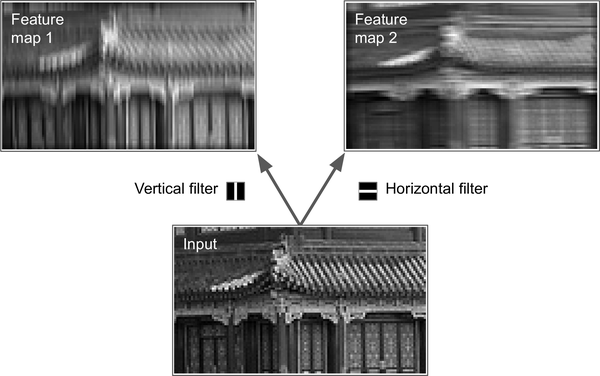

First filter: 
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
Second filter: 
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


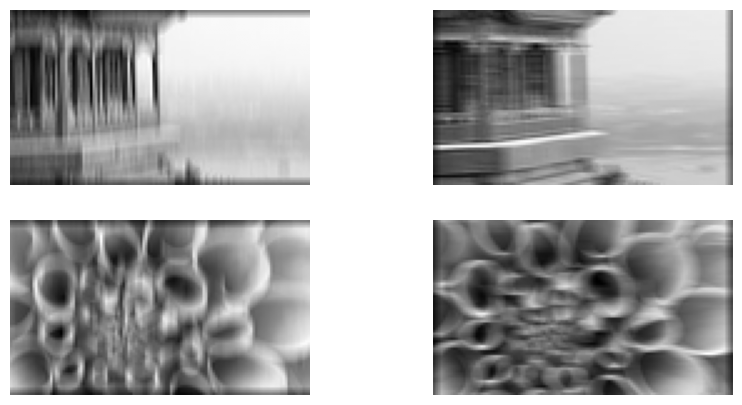

In [ ]:
# Let's manually create two filters to see if we can get similar images to those in Figure 14–5 (above)

plt.figure(figsize=(10, 5))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1 # first filter (index 0); 4th row (index 3), set to 1
filters[3, :, :, 1] = 1 # second filter (index 1); 4th column (index 3) set to 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

print("First filter: ")
print(filters[:, :, 0, 0])
print("Second filter: ")
print(filters[:, :, 0, 1])

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

Notice the dark lines at the top and bottom of the two images on the left, and on the left and right of the two images on the right? Can you guess what these are? Why were they not present in the previous figures?

You guessed it! These are artifacts due to the fact that we used zero padding in this case, while we did not use zero padding to create the feature maps in the previous figure. Because of zero padding, the two feature maps based on the vertical line filter (i.e., the two left images) could not fully activate near the top and bottom of the images. Similarly, the two feature maps based on the horizontal line filter (i.e., the two right images) could not fully activate near the left and right of the images.

# Pooling Layers
## Implementing Pooling Layers With Keras

**Max pooling**

In [ ]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2) # size of the window over which the maximum value is taken (2x2 window)

In [ ]:
output = max_pool(images)

In [ ]:
output.shape

TensorShape([2, 35, 60, 3])

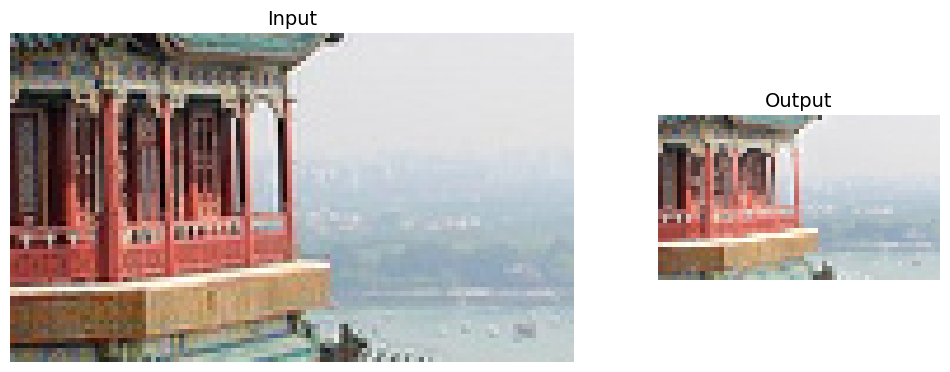

In [ ]:
# max pooling with stride = 2

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

**Global Average Pooling**

In [ ]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

The following layer is equivalent:

In [ ]:
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [ ]:
output_avg = global_avg_pool(images) # Each channel is reduced to a single value by averaging all the values in that channel
output_avg

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.643388  , 0.59718215, 0.5825038 ],
       [0.7630747 , 0.26010972, 0.10848834]], dtype=float32)>

In [ ]:
output_avg.shape

TensorShape([2, 3])

1. These are the main advantages of a CNN over a fully connected DNN for image classification:
    * Because consecutive layers are only partially connected and because it heavily reuses its weights, a CNN has many fewer parameters than a fully connected DNN, which makes it much faster to train, reduces the risk of overfitting, and requires much less training data.
    * When a CNN has learned a kernel that can detect a particular feature, it can detect that feature anywhere in the image. In contrast, when a DNN learns a feature in one location, it can detect it only in that particular location. Since images typically have very repetitive features, CNNs are able to generalize much better than DNNs for image processing tasks such as classification, using fewer training examples.
    * Finally, a DNN has no prior knowledge of how pixels are organized; it does not know that nearby pixels are close. A CNN's architecture embeds this prior knowledge. Lower layers typically identify features in small areas of the images, while higher layers combine the lower-level features into larger features. This works well with most natural images, giving CNNs a decisive head start compared to DNNs.
2. If your GPU runs out of memory while training a CNN, here are five things you could try to solve the problem (other than purchasing a GPU with more RAM):
    * Reduce the mini-batch size.
    * Reduce dimensionality using a larger stride in one or more layers.
    * Remove one or more layers.
    * Use 16-bit floats instead of 32-bit floats.
    * Distribute the CNN across multiple devices.
3. A max pooling layer has no parameters at all, whereas a convolutional layer has quite a few.


## High Accuracy CNN for MNIST
_Exercise: Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST._

The following model uses 2 convolutional layers, followed by 1 pooling layer, then dropout 25%, then a dense layer, another dropout layer but with 50% dropout, and finally the output layer. It reaches about 99.2% accuracy on the test set. This places this model roughly in the top 20% in the [MNIST Kaggle competition](https://www.kaggle.com/c/digit-recognizer/) (if we ignore the models with an accuracy greater than 99.79% which were most likely trained on the test set, as explained by Chris Deotte in [this post](https://www.kaggle.com/c/digit-recognizer/discussion/61480)). Can you do better? To reach 99.5 to 99.7% accuracy on the test set, you need to add image augmentation, batch norm, use a learning schedule such as 1-cycle, and possibly create an ensemble.

In [ ]:
mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("X_test shape:", X_test.shape)

X_train shape: (55000, 28, 28, 1)
X_valid shape: (5000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


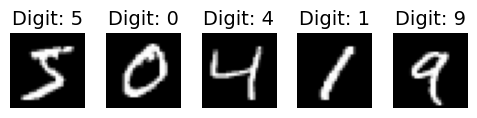

In [ ]:
# Plot a few examples
plt.figure(figsize=(5, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i, :, :, 0], cmap='gray')
    plt.title(f"Digit: {y_train[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.build(input_shape=(None, 28, 28, 1))
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,866 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)